In [75]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
import random
import numba
from collections import defaultdict
from sortedcontainers import SortedDict

In [76]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [77]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass

class EdgeNeighborhood:
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = []
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes = np.array(self.indexes)
        self.size = len(self.indexes)
        
        # Precompute vertex to moves mapping
        self.vertex_to_moves = defaultdict(set)
        for idx, (i, j) in enumerate(self.indexes):
            # For edge neighborhood, we need to map all vertices in the range
            for vertex in range(i-1, j+2):
                self.vertex_to_moves[vertex % n].add(idx)
    
    def neighborhood_size(self):
        return self.size
    
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        if indexes is None:
            indexes = np.arange(len(self.indexes))
        indexes=self.indexes[indexes]
        i_vals, j_vals = indexes[:, 0], indexes[:, 1]
        s = np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]
        i1 = solution[i - 1]
        i2 = solution[i]
        j1 = solution[j]
        j2 = solution[(j + 1)%n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        # Instead of checking all moves, directly get affected moves from precomputed mapping
        affected = set()
        n = len(solution)
        for vertex in range(start, end):
            affected.update(self.vertex_to_moves[vertex % n])
        return list(affected)

class InterNeighborhood:
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = []
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes = np.array(self.indexes)
        self.size = len(self.indexes)
        
        # Precompute mappings
        self.vertex_to_moves = defaultdict(set)  # For selected vertices
        self.unselected_to_moves = defaultdict(set)  # For unselected vertices
        for idx, (i, j) in enumerate(self.indexes):
            # Map selected vertex and its neighbors
            self.vertex_to_moves[i].add(idx)
            self.vertex_to_moves[(i-1) % n].add(idx)
            self.vertex_to_moves[(i+1) % n].add(idx)
            # Map unselected vertex
            self.unselected_to_moves[j].add(idx)
    
    def neighborhood_size(self):
        return self.size
    
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes))
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s = np.array(solution)
        u = np.array(unselected_list)
        node_prev = s[i_prev]
        node_current = s[indices_i]
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]
        j1 = unselected[j]
        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        # Use precomputed mappings to get affected moves
        affected = set()
        # Add moves affected by the selected vertex and its neighbors
        affected.update(self.vertex_to_moves[i])
        affected.update(self.vertex_to_moves[(i-1) % n])
        affected.update(self.vertex_to_moves[(i+1) % n])
        # Add moves affected by the unselected vertex
        affected.update(self.unselected_to_moves[j])
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]

def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)

    solution = starting_solution.copy()

    while True:
        objective_changes = neighborhood.batch_get_differences(solution, unselected)
        best_index = np.argmin(objective_changes)
    
        if objective_changes[best_index] >= 0:
            return solution
    
        solution = neighborhood.modify_solution(best_index, solution, unselected)


n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [78]:
pop_size=20

In [79]:

            

class SteepestLocalSearch:
    def __init__(self, starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: 'Neighborhood'):
        self.solution = starting_solution.copy()
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.neighborhood = neighborhood
        self.unselected = SortedList(range(len(costs)))
        for i in starting_solution:
            self.unselected.remove(i)
        self.LM = {} 

    def initialize_moves(self):
        deltas=self.neighborhood.batch_get_differences(self.solution, self.unselected)
        idx=np.where(deltas < 0)[0]
        for i in idx:

            self.LM[i] = deltas[i]

    def update_moves(self, affected_indexes: List[int]):
        deltas=self.neighborhood.batch_get_differences(self.solution, self.unselected)
    
        for idx in affected_indexes:
            if deltas[idx] < 0:
                self.LM[idx] = deltas[idx]
            elif idx in self.LM:
                del self.LM[idx]
    def find_best_move(self):
        best_move = None
        best_delta = float('inf')
        
        for idx, delta in self.LM.items():
            if delta >= best_delta:
                continue
                
            move = (idx, delta)
            app = self.is_move_applicable(move)
            if app == 1:
                best_delta = delta
                best_move = move
                
        return best_move
    def get_sorted_moves(self):
        return sorted(self.LM.items(), key=lambda x: x[1])

    def is_move_applicable(self, move: Tuple[int, float]) -> bool:
        ind, _ = move
        i, j = self.neighborhood.indexes[ind]
        current_edges = {(self.solution[k], self.solution[(k + 1) % len(self.solution)]) for k in range(len(self.solution))}
        move_edges = {(self.solution[i - 1], self.solution[i]), (self.solution[j], self.solution[(j + 1) % len(self.solution)])}
        reversed_edges = {(b, a) for (a, b) in move_edges}

    
        if move_edges.isdisjoint(current_edges) and reversed_edges.isdisjoint(current_edges):
            return 0 
        elif move_edges.issubset(reversed_edges):
            return 2  
        return 1  

    def apply_move(self, move: Tuple[int, float]) -> List[int]:
        ind, _ = move
        affected_indexes = self.neighborhood.get_affected_indexes(ind, self.solution)
        self.solution = self.neighborhood.modify_solution(ind, self.solution, self.unselected)
        return affected_indexes

    def steepest_search(self):
        self.initialize_moves()
        while True:
            best_move = self.find_best_move()
            if best_move is None:
                return self.solution
                
            affected_indexes = self.apply_move(best_move)
            del self.LM[best_move[0]]
            self.update_moves(affected_indexes) 

            

In [80]:
def greedy_2_regret_weighted(starting_solution: np.ndarray, distance_matrix: np.ndarray, costs: np.ndarray, weight_regret=0.5) -> list:
    cost_matrix = (distance_matrix + costs).T 
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cycle = starting_solution.copy() 
    unvisited = np.ones(n, dtype=bool)
    unvisited[cycle] = 0 
  
    while len(cycle) < num_nodes_to_use:
        cycle_len = len(cycle)
        unvisited_indices = np.where(unvisited)[0]
        j_indices = np.arange(cycle_len)
        k_indices = (j_indices + 1) % cycle_len  
        cost_increases = (
            cost_matrix[cycle[j_indices], unvisited_indices[:, None]] +  
            cost_matrix[unvisited_indices[:, None], cycle[k_indices]] - 
            cost_matrix[cycle[j_indices], cycle[k_indices]]
        )
        best_increases = np.min(cost_increases, axis=1)  
        second_best_increases = np.partition(cost_increases, 1, axis=1)[:, 1] 
        
        weighted= best_increases - weight_regret*second_best_increases

        max_weighted_idx = np.argmin(weighted)
        i = unvisited_indices[max_weighted_idx]
        best_position = np.argmin(cost_increases[max_weighted_idx])
        cycle = np.insert(cycle, (best_position + 1) % cycle_len, i) 
        unvisited[i] = False  
    return cycle

In [81]:
start_pop=[SteepestLocalSearch(get_random_solution(200), dist, costs, neighborhood).steepest_search() for x in range(pop_size)]


In [82]:
sc1=sorted([score(x, dist, costs) for x in start_pop])
def get_child(p1,p2):
    common_nodes=set(p1)&set(p2)
    to_fill=list(set(range(200))-common_nodes)

    c1,c2=np.full(100, -1),np.full(100, -1)
    common_nodes=np.array(list(common_nodes)).reshape(1, len(common_nodes))
    p1n,p2n=np.array(p1).reshape(len(p1), 1),np.array(p2).reshape(len(p2), 1)
    
    f1,f2=np.where(np.any(p1n==common_nodes, axis=1))[0],np.where(np.any(p2n==common_nodes, axis=1))[0]
    c1[f1], c2[f2]=(p1n[f1]).reshape(-1),(p2n[f2]).reshape(-1)
    np.random.shuffle(to_fill)
    l=len(p1)-common_nodes.shape[-1]
    c1[np.where(c1==-1)[0]]=to_fill[:l]
    np.random.shuffle(to_fill)
    
    c2[np.where(c2==-1)[0]]=to_fill[:l]
    return c1.tolist(), c2.tolist()
def get_child_repair(p1,p2, dist,costs):
    common_nodes=set(p1)&set(p2)
    to_fill=list(set(range(200))-common_nodes)

    c1,c2=np.full(100, -1),np.full(100, -1)
    common_nodes=np.array(list(common_nodes)).reshape(1, len(common_nodes))
    p1n,p2n=np.array(p1).reshape(len(p1), 1),np.array(p2).reshape(len(p2), 1)
    
    f1,f2=np.where(np.any(p1n==common_nodes, axis=1))[0],np.where(np.any(p2n==common_nodes, axis=1))[0]
    c1, c2=(p1n[f1]).reshape(-1),(p2n[f2]).reshape(-1)
    
    c1=greedy_2_regret_weighted(c1, dist, costs)
    c2=greedy_2_regret_weighted(c2, dist, costs)
    return c1.tolist(), c2.tolist()

def ev(start_pop, dit, coss,neighborhoo, repair, ls):
    pop=start_pop.copy()
    start_time=time.time()
    it=0
    scores=[score(x, dit, coss) for x in pop]

    l=max(scores)
    worst=scores.index(l)

    while time.time()-start_time<25:  
        it+=1
    
        i,j=np.random.randint(0, pop_size, 2)
        if repair:
            c1,c2=get_child_repair(pop[i], pop[j], dit, coss)
        else:
            c1,c2=get_child(pop[i], pop[j])
        if ls:
            st=SteepestLocalSearch(c1, dit, coss, neighborhoo)
            c1=st.steepest_search()
            st=SteepestLocalSearch(c2, dit, coss, neighborhoo)
            c2=st.steepest_search()
        
        if c1 not in pop:
            sc=score(c1, dit, coss)
            if sc<l:
                pop.pop(worst)
                scores.pop(worst)
                pop.append(c1)
                scores.append(sc)
                l=max(scores)
                worst=scores.index(l)
        if c2 not in pop:
            sc=score(c2, dit, coss)
            if sc<l:
                pop.pop(worst)
                scores.pop(worst)
                pop.append(c2)
                scores.append(sc)
                l=max(scores)
                worst=scores.index(l)
           
        
    
        pop=pop[:pop_size]
    return pop, it



In [106]:
data=[]

In [107]:
def test_method(dists, cost,Neighborhood: CombinedNeighborhood, coordinate, repair, ls, start_pop, name=''):
    mins_2=[]
    sols_2=[]
    avgs_2=[]
    maxs_2=[]
    i1=[]
    for x in range(20):
        
        pop, i=ev(start_pop, dists, cost, Neighborhood, repair, ls)
        pop=sorted(pop, key=lambda x: score(x, dists, cost))
        i1.append(i)
        sols_2.append(pop[0])
        sc=[score(x, dists, cost) for x in pop]
        mins_2.append(min(sc))
        avgs_2.append(sum(sc)/len(sc))
        maxs_2.append(max(sc))
    print('scores: ', min(mins_2), sum(avgs_2)/len(avgs_2), max(maxs_2), np.mean(mins_2), np.mean(maxs_2), np.mean(avgs_2))
    print(sols_2[mins_2.index(min(mins_2))])
    data.append([name, f'{np.mean(mins_2)} ({np.mean(avgs_2)} - {np.mean(maxs_2)})', sols_2[mins_2.index(min(mins_2))], f'{min(i1)} ({sum(i1)/len(i1)} - {max(i1)})', f'{np.mean([score(x,dists, cost) for x in start_pop]-np.mean(avgs_2))}'])
    if len(i1)>0:
        print(f'iterations: ', min(i1), sum(i1)/len(i1), max(i1))
    plot_solution(sols_2[mins_2.index(min(mins_2))], coordinate, cost, f'best solution for {name}')

In [108]:
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhoodA = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

interNeighborhoodB = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhoodB = EdgeNeighborhood(distb, costsb, n // 2)
neighborhoodB = CombinedNeighborhood([edgeNeighborhoodB, interNeighborhoodB])

scores:  72152 74761.19999999998 76827 72152.0 76827.0 74761.19999999998
[137, 176, 80, 94, 63, 79, 133, 162, 151, 51, 118, 59, 65, 47, 116, 43, 42, 96, 159, 193, 41, 115, 139, 68, 46, 0, 143, 117, 93, 69, 18, 22, 146, 181, 34, 160, 54, 177, 184, 4, 112, 35, 131, 149, 123, 127, 70, 135, 154, 180, 53, 86, 75, 101, 100, 26, 97, 1, 152, 2, 120, 44, 16, 171, 175, 113, 56, 31, 78, 145, 179, 92, 129, 57, 55, 52, 178, 3, 106, 185, 165, 119, 40, 196, 81, 90, 27, 164, 21, 138, 14, 49, 144, 62, 9, 148, 186, 89, 183, 23]
iterations:  123763 125005.6 126309


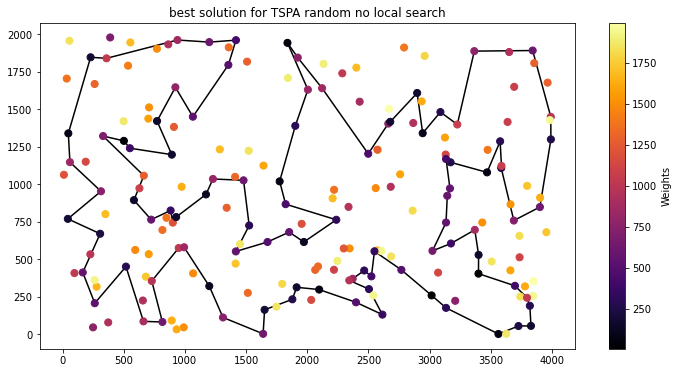

scores:  69456 70052.3225 70442 69868.2 70155.85 70052.3225
[1, 97, 152, 2, 129, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 57, 179, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 14, 144, 49, 102, 62, 9, 148, 124, 94, 63, 79, 133, 162, 151, 51, 80, 176, 137, 23, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 159, 193, 41, 139, 68, 46, 115, 118, 59, 65, 116, 43, 42, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 131, 149, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101]
iterations:  414 670.05 955


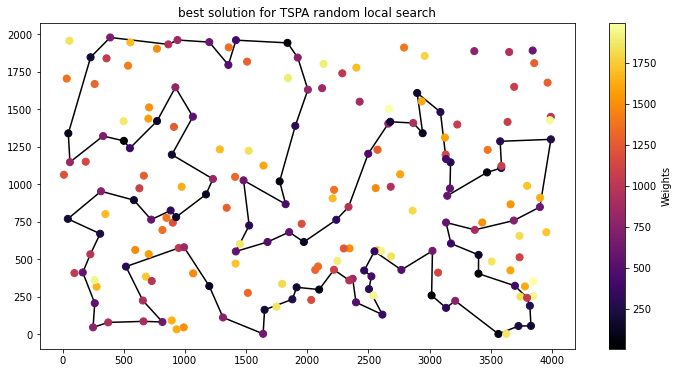

scores:  70368 70956.225 71589 70622.6 71202.0 70956.225
[65, 59, 118, 51, 151, 162, 133, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 49, 144, 14, 138, 178, 106, 52, 55, 57, 185, 40, 119, 165, 90, 81, 196, 157, 31, 56, 113, 175, 171, 16, 25, 44, 120, 78, 145, 179, 92, 129, 2, 75, 86, 101, 1, 152, 97, 26, 100, 53, 180, 154, 135, 70, 127, 123, 112, 4, 84, 35, 184, 177, 54, 48, 160, 34, 181, 42, 5, 41, 193, 159, 146, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 46, 68, 139, 115, 43, 116]
iterations:  11118 14251.1 20516


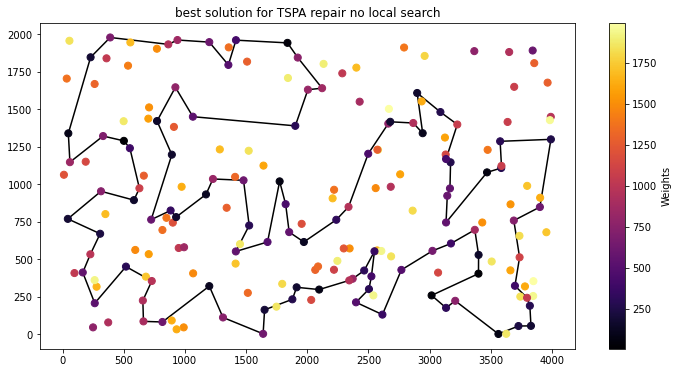

scores:  69796 70534.99499999998 71052 70236.15 70802.65 70534.995
[143, 0, 117, 93, 140, 108, 18, 22, 146, 34, 160, 184, 54, 177, 10, 190, 4, 112, 84, 35, 131, 149, 65, 116, 43, 42, 181, 159, 193, 41, 139, 68, 46, 115, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 97, 1, 101, 86, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 90, 27, 164, 7, 21, 14, 144, 62, 9, 148, 102, 49, 178, 106, 165, 40, 185, 52, 55, 57, 92, 129, 2, 152, 94, 63, 79, 80, 176, 137, 23, 89, 183]
iterations:  4199 5146.8 6515


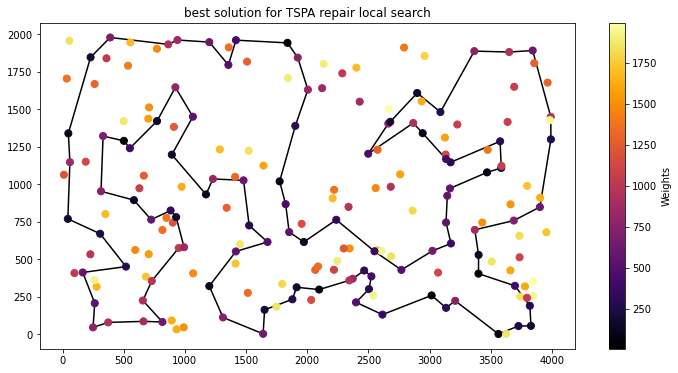

scores:  47621 48936.599999999984 51420 47621.0 51420.0 48936.59999999999
[106, 124, 62, 83, 18, 55, 34, 170, 152, 183, 140, 4, 149, 20, 148, 47, 94, 179, 99, 130, 95, 185, 86, 166, 194, 176, 180, 113, 114, 127, 89, 103, 163, 153, 187, 146, 81, 77, 141, 61, 36, 5, 78, 175, 142, 45, 80, 190, 73, 54, 31, 193, 117, 1, 38, 135, 32, 102, 63, 40, 107, 100, 122, 133, 10, 147, 6, 188, 169, 132, 13, 195, 168, 145, 70, 3, 155, 184, 189, 109, 35, 0, 29, 160, 33, 138, 182, 51, 191, 90, 131, 121, 25, 177, 21, 87, 82, 8, 111, 143]
iterations:  115271 120589.75 127070


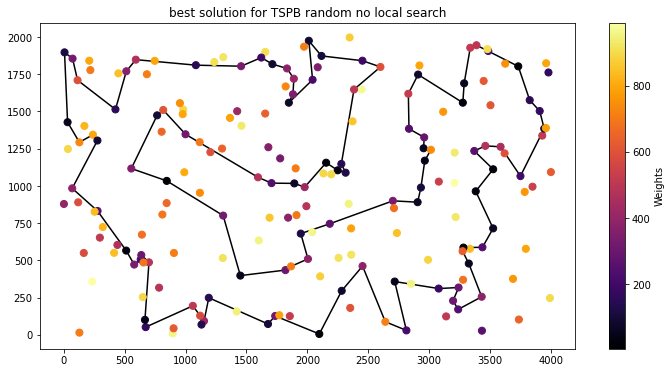

scores:  43808 44390.74749999999 45035 44220.35 44500.15 44390.7475
[104, 8, 21, 82, 111, 144, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 60, 148, 47, 94, 66, 179, 185, 130, 95, 86, 166, 194, 176, 180, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 61, 36, 177, 5, 78, 175, 142, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 63, 40, 107, 10, 133, 122, 135, 131, 121, 51, 90, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139, 11, 182, 138]
iterations:  149 315.3 514


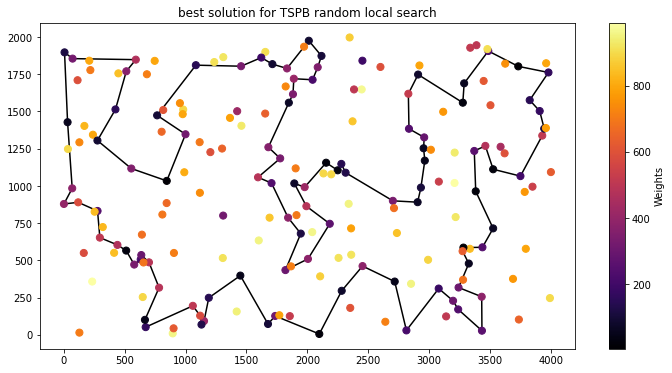

scores:  44773 45270.2125 45729 44999.0 45474.95 45270.212499999994
[187, 153, 81, 77, 141, 82, 111, 35, 109, 0, 29, 11, 139, 182, 138, 33, 160, 144, 104, 8, 21, 61, 36, 177, 5, 78, 175, 162, 80, 190, 136, 73, 193, 31, 54, 117, 198, 156, 1, 16, 27, 38, 63, 40, 107, 133, 122, 135, 131, 121, 51, 90, 147, 6, 188, 169, 132, 13, 195, 168, 145, 15, 70, 3, 155, 184, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 130, 95, 86, 128, 18, 55, 34, 62, 124, 106, 176, 113, 194, 166, 114, 137, 127, 89, 103, 163]
iterations:  7120 11291.8 19149


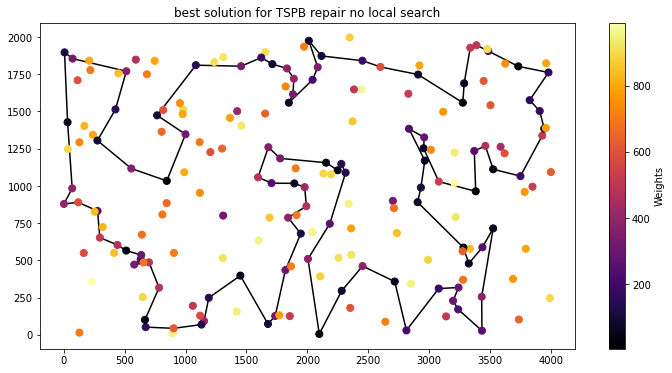

scores:  44409 44827.1725 45299 44635.05 44996.4 44827.1725
[11, 138, 182, 25, 158, 121, 51, 90, 122, 107, 40, 63, 135, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 162, 45, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 144, 111, 82, 8, 104, 33, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 134, 139]
iterations:  3435 4416.75 5325


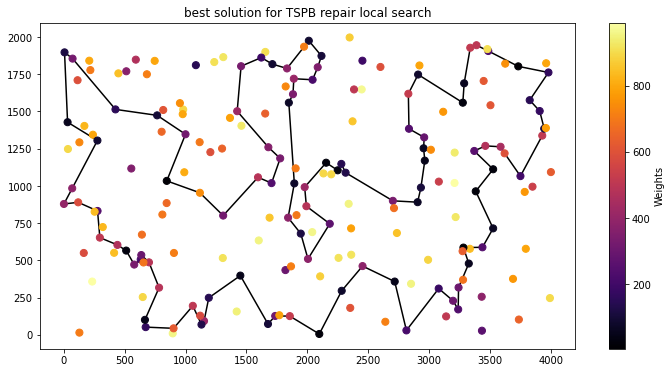

In [109]:

instances=[(dist, costs, neighborhoodA, coordinates), (distb, costsb, neighborhoodB, coordinatesb)]
for tsp_instance in range(2):
    for repair in range(2):
        for ls in range(2):
            instance=instances[tsp_instance]
            if tsp_instance==0:
                name='TSPA'
            else:
                name='TSPB'
            if repair == 0:
                name+=' random'
            else:
                    name+=' repair'
            if ls == 0:
                name+=' no local search'
            else:
                name+=' local search'
            start_pop=[SteepestLocalSearch(get_random_solution(200), *instance[:3]).steepest_search() for x in range(pop_size)]
            test_method(*instance, repair, ls,start_pop, name)


In [110]:
d=pd.DataFrame(columns=['name', 'score', 'sol', 'iter', 'diff'], data=data)

In [112]:
d.head()

,name,score,sol,iter,diff
0,TSPA random no local search,72152.0 (74761.19999999998 - 76827.0),"[137, 176, 80, 94, 63, 79, 133, 162, 151, 51, ...",123763 (125005.6 - 126309),1.746229827404022e-11
1,TSPA random local search,69868.2 (70052.3225 - 70155.85),"[1, 97, 152, 2, 129, 120, 44, 25, 16, 171, 175...",414 (670.05 - 955),4888.727500000005
2,TSPA repair no local search,70622.6 (70956.225 - 71202.0),"[65, 59, 118, 51, 151, 162, 133, 176, 80, 79, ...",11118 (14251.1 - 20516),4150.274999999994
3,TSPA repair local search,70236.15 (70534.995 - 70802.65),"[143, 0, 117, 93, 140, 108, 18, 22, 146, 34, 1...",4199 (5146.8 - 6515),4760.4550000000045
4,TSPB random no local search,47621.0 (48936.59999999999 - 51420.0),"[106, 124, 62, 83, 18, 55, 34, 170, 152, 183, ...",115271 (120589.75 - 127070),8.73114913702011e-12


In [113]:
d.to_csv('data.csv')